# Solar Charge Predictor #
## Contents
1. Introduction
2. Data Preparation
    1. Importing Data
    1. Calculating Age
    1. Removing Very Old Bridges
    1. Merging Small Categories
    1. Converting Ratings into Scores
    1. Cleaned Data Ready for Analysis
3. Exploratory Analysis
    1. Correlations Heatmap
    1. Bridge Type with Spread of their Condition
    1. Bridge Type with Spread of Daily Average Traffic
    1. Bridge Type with Spread of Percentage Trucks
    1. Bridge Type with Spread of Ages
    1. Relationship between Design and Material
        1. Material given Design
        1. Design given Material
    1. Summary of Exploratory Analysis
4. Regression Modelling
    1. Checking distribution of the Condition Score
    1. Visual look at the Numerical Factors
    1. Trend Calculation between Factors and Bridge Condition
        1. Precision of the Regression
        1. Age and Traffic
        1. Material
        1. Design
6. Conclusion

## 1. Introduction
Given the economy 7 electricity tariff, using electricity from the grid at night is cheaper than during the day. It is cost-effective to charge the house battery at night, and discharge it during the day when electricity is expensive to import. However, given a battery and solar panels, if batteries are charged excessively, then the excess generated by the solar panels (during daytime) will be exported for less than it costs to import from the grid (at the nighttime rate).

Therefore, factors are selected to predict what percentage charge of battery should be required on a given day. Weather factors are provided by www.visualcrossing.com for the author's location.

Of the raw data, I will begin with the following factors:

Table 1: Factor Description

| Factor        |      Description             | Values   | 
|:--------------|:-----------------------------|:------:|
|Day            | Day of the week (precategorised)| Weekday, Saturday, Sunday, Monday | 
|prec_cover     | The percent of precipitation cover | % |
|cloud_cover    | The percent of cloud cover   | % |
|solar_energy   | Units of solar energy        | float |
|sunset         | Time at which the sun sets as a fraction of 24 hours | float (0-1) |
|charge_to      | The ideal % to charge the battery to    | % |

## 2. Data Preparation ##

## 2. A. Data Collection
Data regarding the photovoltaic system was extracted from the APK of the inverter manufacturer. Given that the battery was charged to some % at night, the optimal charge_to % would have to be calculated from the grid export (KWh) or % free battery space. Therefore, this was calculated in excel via a formula following this logic:

```
if peak_percent >= 98: #when exporting
    if charged_percent - (100*(export/10.12)) < 0: #if the export is more than battery capacity make it 0%
        charge_to = 0
    else: #otherwise you should have left how much was exported as free space
        charge_to = charged_percent - (100*(export/10.12))
else: # no export
    if peak_percent < 23: #if peak lower than 23% charge fully
        charge_to = 100
    elif 100-peak_percent+charged_percent > 100: # if peak + charged at night did not reach capacity, charge fully
        charge_to = 100
    else: # otherwise the sum between the peak and charge, compared to capacity is what you should've charged
        charge_to = 100-peak_percent+charged_percent
```

The data collection spreadsheet can be viewed in an attached file.

In [7]:
def what_charge(peak_percent, charged_percent, export):
    if peak_percent >= 98: #when exporting
        if charged_percent - (100*(export/10.12)) < 0: #if the export is more than battery capacity make it 0%
            charge_to = 0
        else: #otherwise you should have left how much was exported as free space
            charge_to = charged_percent - (100*(export/10.12))
    else: # no export
        if peak_percent < 23: #if peak lower than 23% charge fully
            charge_to = 100
        elif 100-peak_percent+charged_percent > 100: # if peak + charged at night did not reach capacity, charge fully
            charge_to = 100
        else: # otherwise the sum between the peak and charge, compared to capacity is what you should've charged
            charge_to = 100-peak_percent+charged_percent
    return charge_to

what_charge(49,22,0)

73

### 2. A. Importing Data
Table 2 shows the start and end of the solar. This 'raw' data was inputted by the author and has been checked for errors.

In [9]:
import pandas as pd

df = pd.read_csv("feb_data.csv")
print("Table 2: Raw Data")
df

Table 2: Raw Data


,day,prec_cover,cloud_cover,solar_energy,sunset,charge_to
0,Weekday,8.33,59.4,8.1,0.762188,98.000000
1,Saturday,29.17,59.5,9.3,0.757465,92.617188
2,Sunday,8.33,30.6,11.1,0.755903,76.000000
3,Monday,8.33,32.6,10.1,0.754363,84.687500
4,Weekday,0.00,6.7,10.5,0.752824,52.273438
...,...,...,...,...,...,...
271,Sunday,50.00,67.3,13.5,0.890833,0.000000
272,Monday,20.83,38.1,17.5,0.890035,0.000000
273,Weekday,41.67,68.0,7.9,0.889213,26.000000
274,Weekday,58.33,70.8,17.6,0.888368,14.187500


### 2. B. One Hot Encoding ###
The days of the week are categorical variables and need to be one-hot encoded for regression. The base category is 'Monday'

In [10]:
days = pd.get_dummies(df.day, drop_first=True) #one hot encoding
print("Table 3: One Hot Encoded Days")
days

Table 3: One Hot Encoded Days


,Saturday,Sunday,Weekday
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,0
4,0,0,1
...,...,...,...
271,0,1,0
272,0,0,0
273,0,0,1
274,0,0,1


In [11]:
combined = days.join(df)
combined = combined.drop(columns=['day'])
print("Table 4: Data Ready for Analysis")
combined

Table 4: Data Ready for Analysis


,Saturday,Sunday,Weekday,prec_cover,cloud_cover,solar_energy,sunset,charge_to
0,0,0,1,8.33,59.4,8.1,0.762188,98.000000
1,1,0,0,29.17,59.5,9.3,0.757465,92.617188
2,0,1,0,8.33,30.6,11.1,0.755903,76.000000
3,0,0,0,8.33,32.6,10.1,0.754363,84.687500
4,0,0,1,0.00,6.7,10.5,0.752824,52.273438
...,...,...,...,...,...,...,...,...
271,0,1,0,50.00,67.3,13.5,0.890833,0.000000
272,0,0,0,20.83,38.1,17.5,0.890035,0.000000
273,0,0,1,41.67,68.0,7.9,0.889213,26.000000
274,0,0,1,58.33,70.8,17.6,0.888368,14.187500


## 3. Exploratory Analysis
### 3. A. Correlations Heatmap
Figure 1 shows the correlation of the different numerical variables, the darker the colour, the more correlated the variable pair. The most significant is solar energy with charge_to. The negative value close to -1 suggests that the higher the solar energy, the lower you should charge the battery. Sunset time is highly correlated with solar energy, hence, to avoid risk of errors and overcomplexity of knowledge this will be dropped.

Other variable correlations are close to 0 which implies there is not much relationship between them.

Figure 1: Correlation Heatmap between Variables


C:\Users\Peter\AppData\Local\Temp\ipykernel_3484\1340555033.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True),


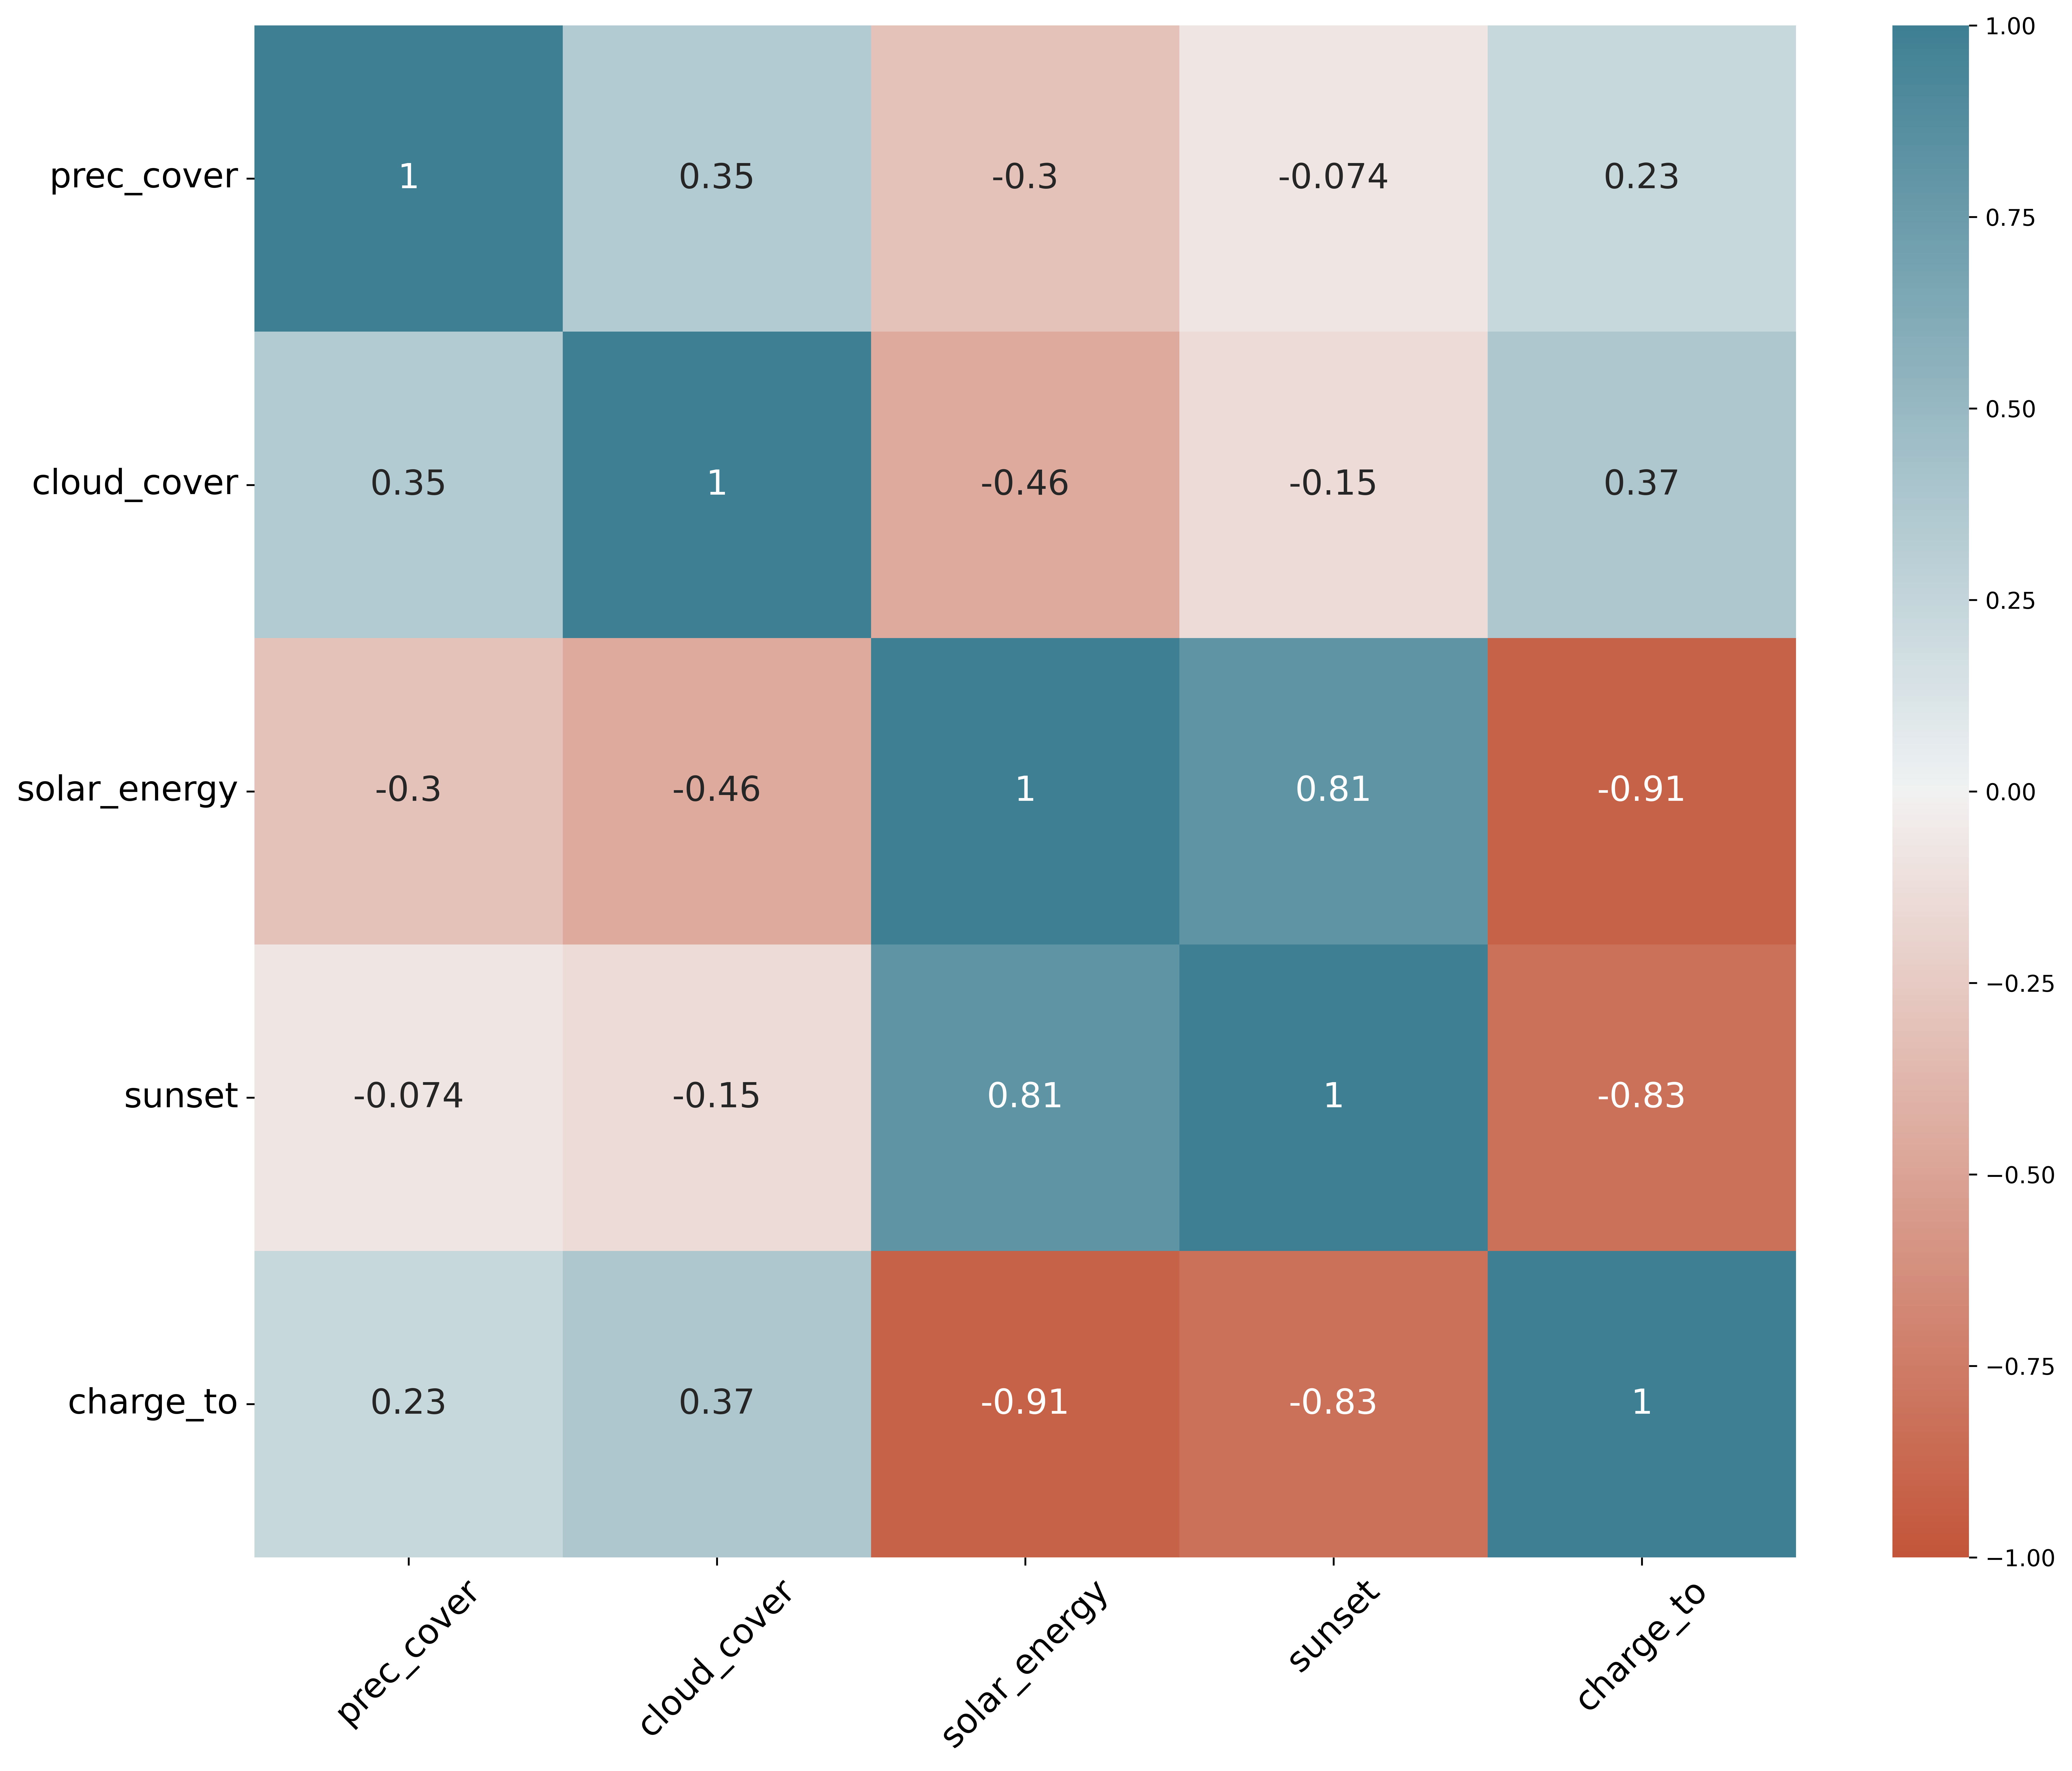

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Figure 1: Correlation Heatmap between Variables")
fig,ax = plt.subplots(1,1, figsize=(15,12), dpi=600,)
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

Figure 2: Charge up to given Solar Energy


Text(0, 0.5, 'Charge up to (%)')

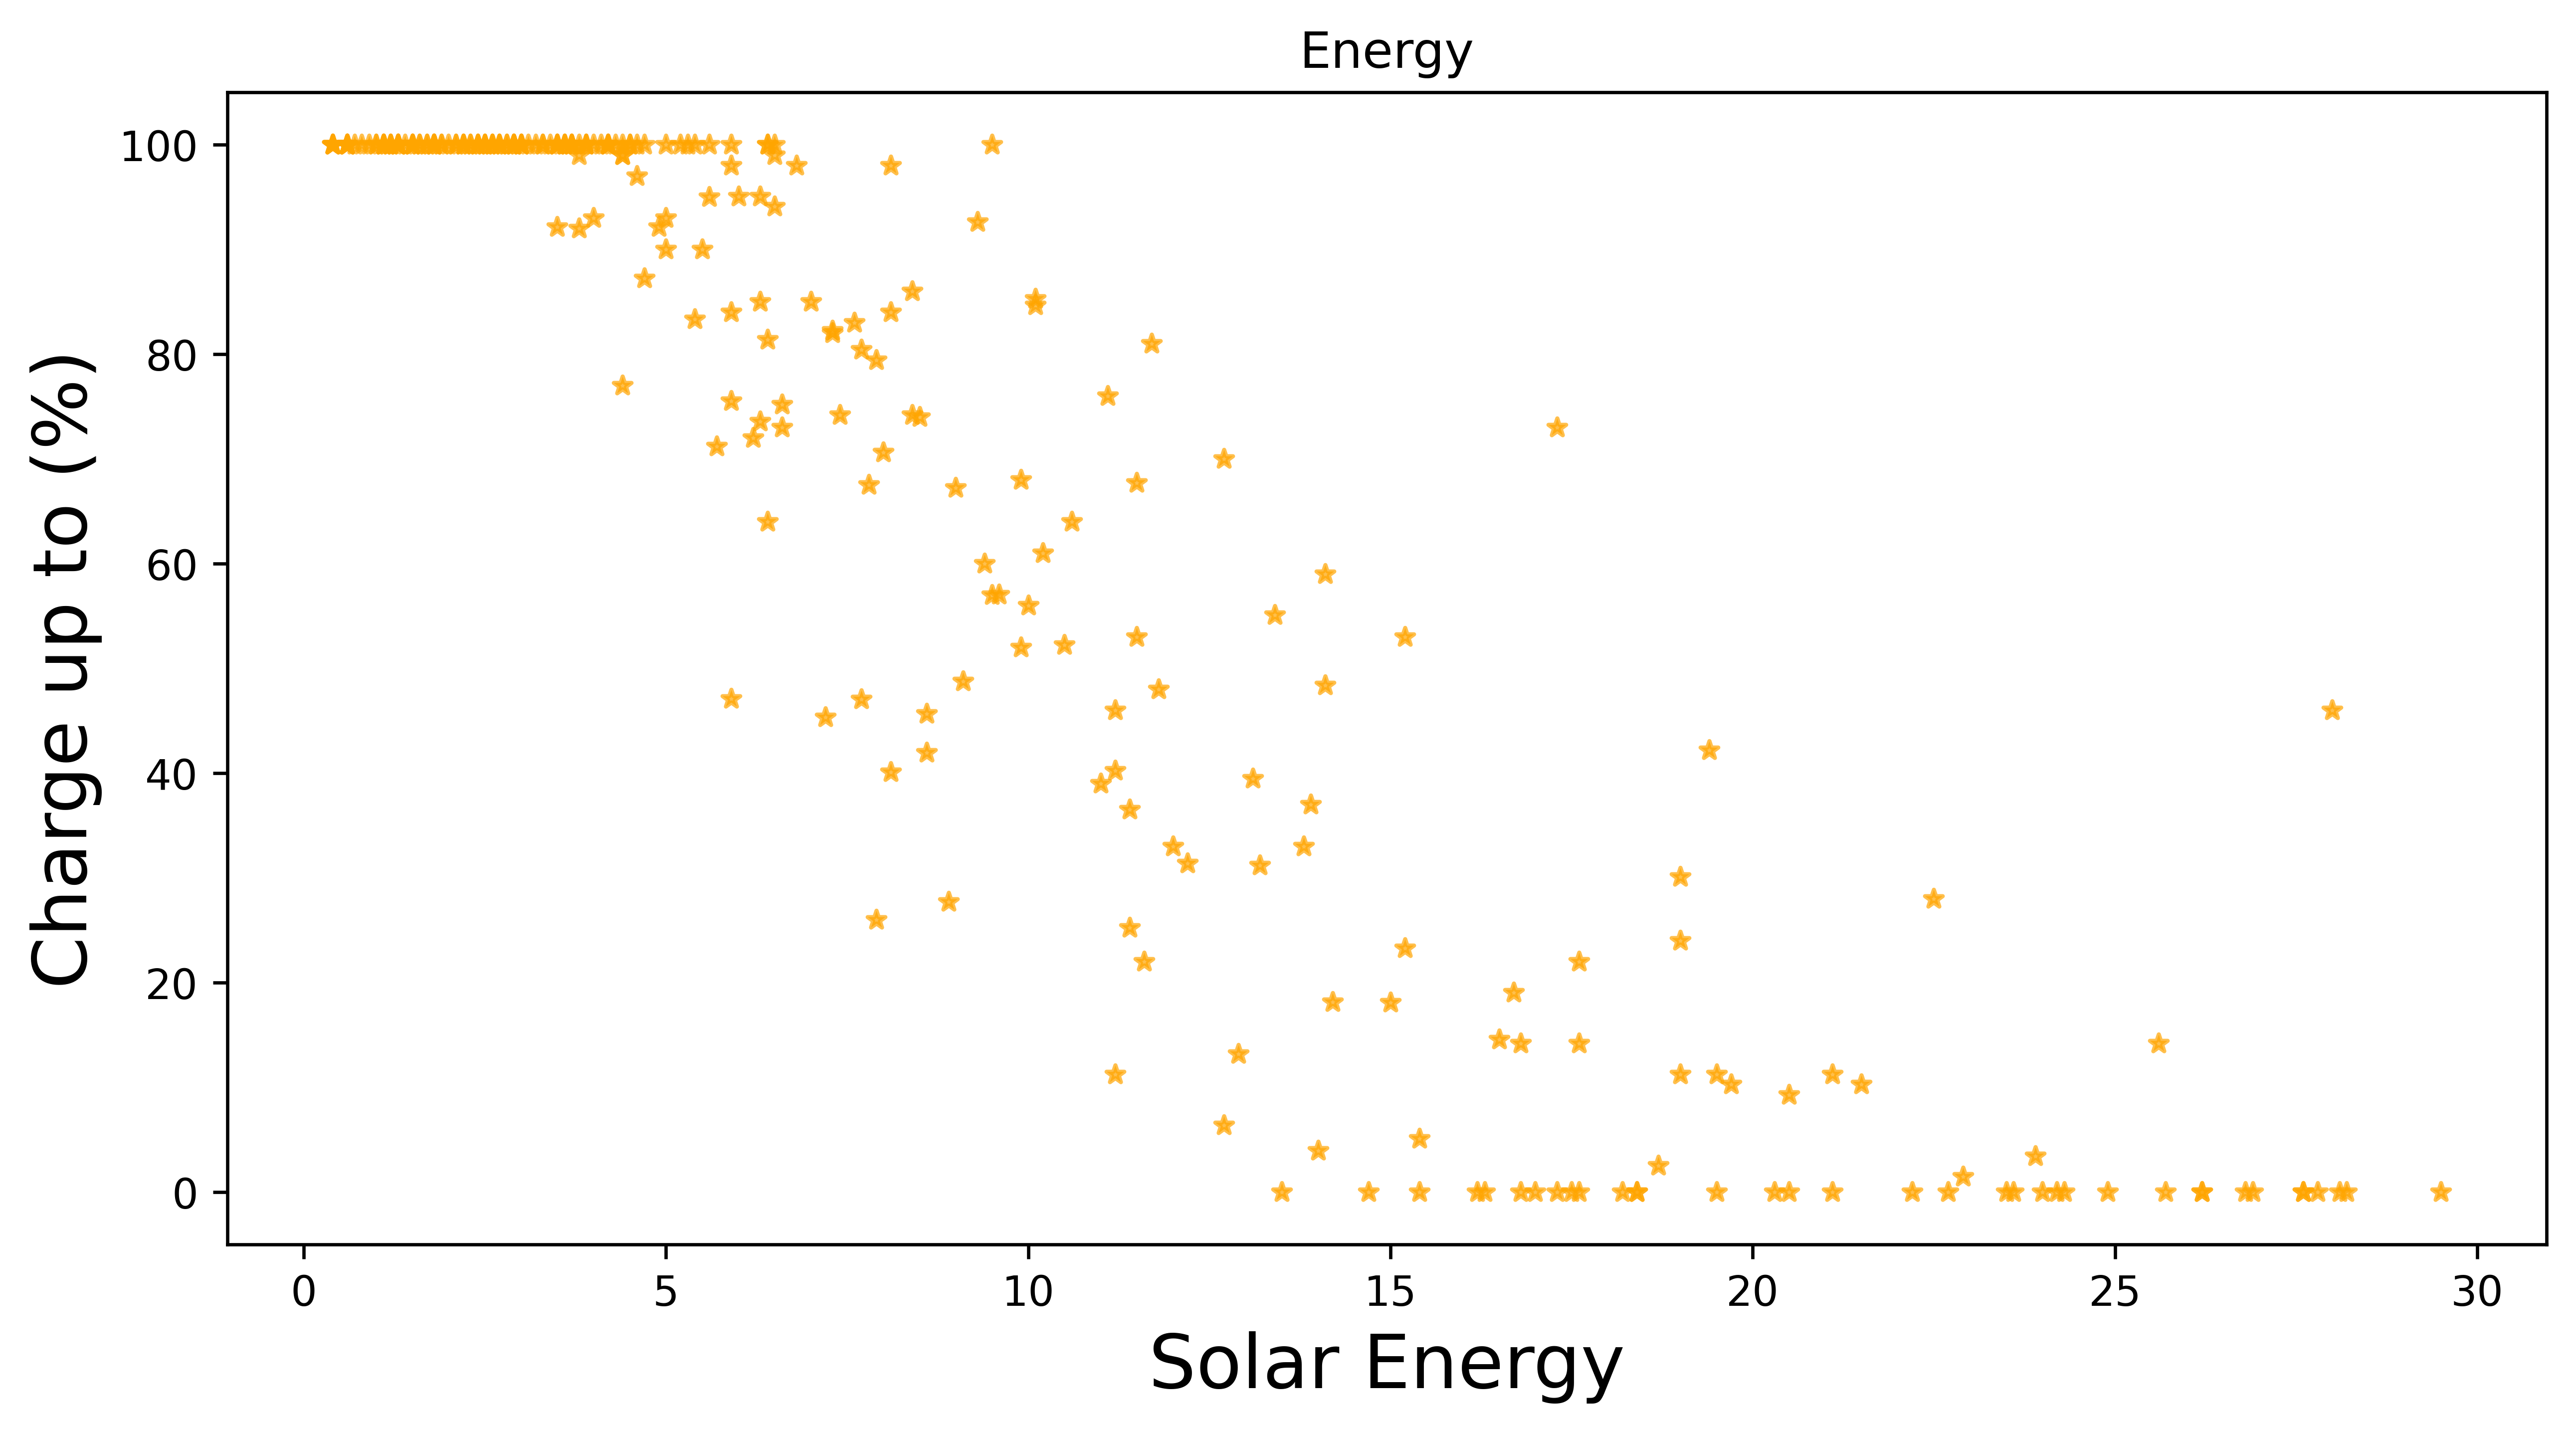

In [16]:
print("Figure 2: Charge up to given Solar Energy")
fig, (a1) = plt.subplots(1,1, dpi=600, figsize=(10,5))

combined.plot(x = "solar_energy", y = "charge_to", kind="scatter", marker='*', color='orange', alpha = 0.7, ax=a1)

a1.set_title("Energy")
a1.set_xlabel("Solar Energy", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)

Figure 3: Charge up to given Sunset time


Text(0, 0.5, 'Charge up to (%)')

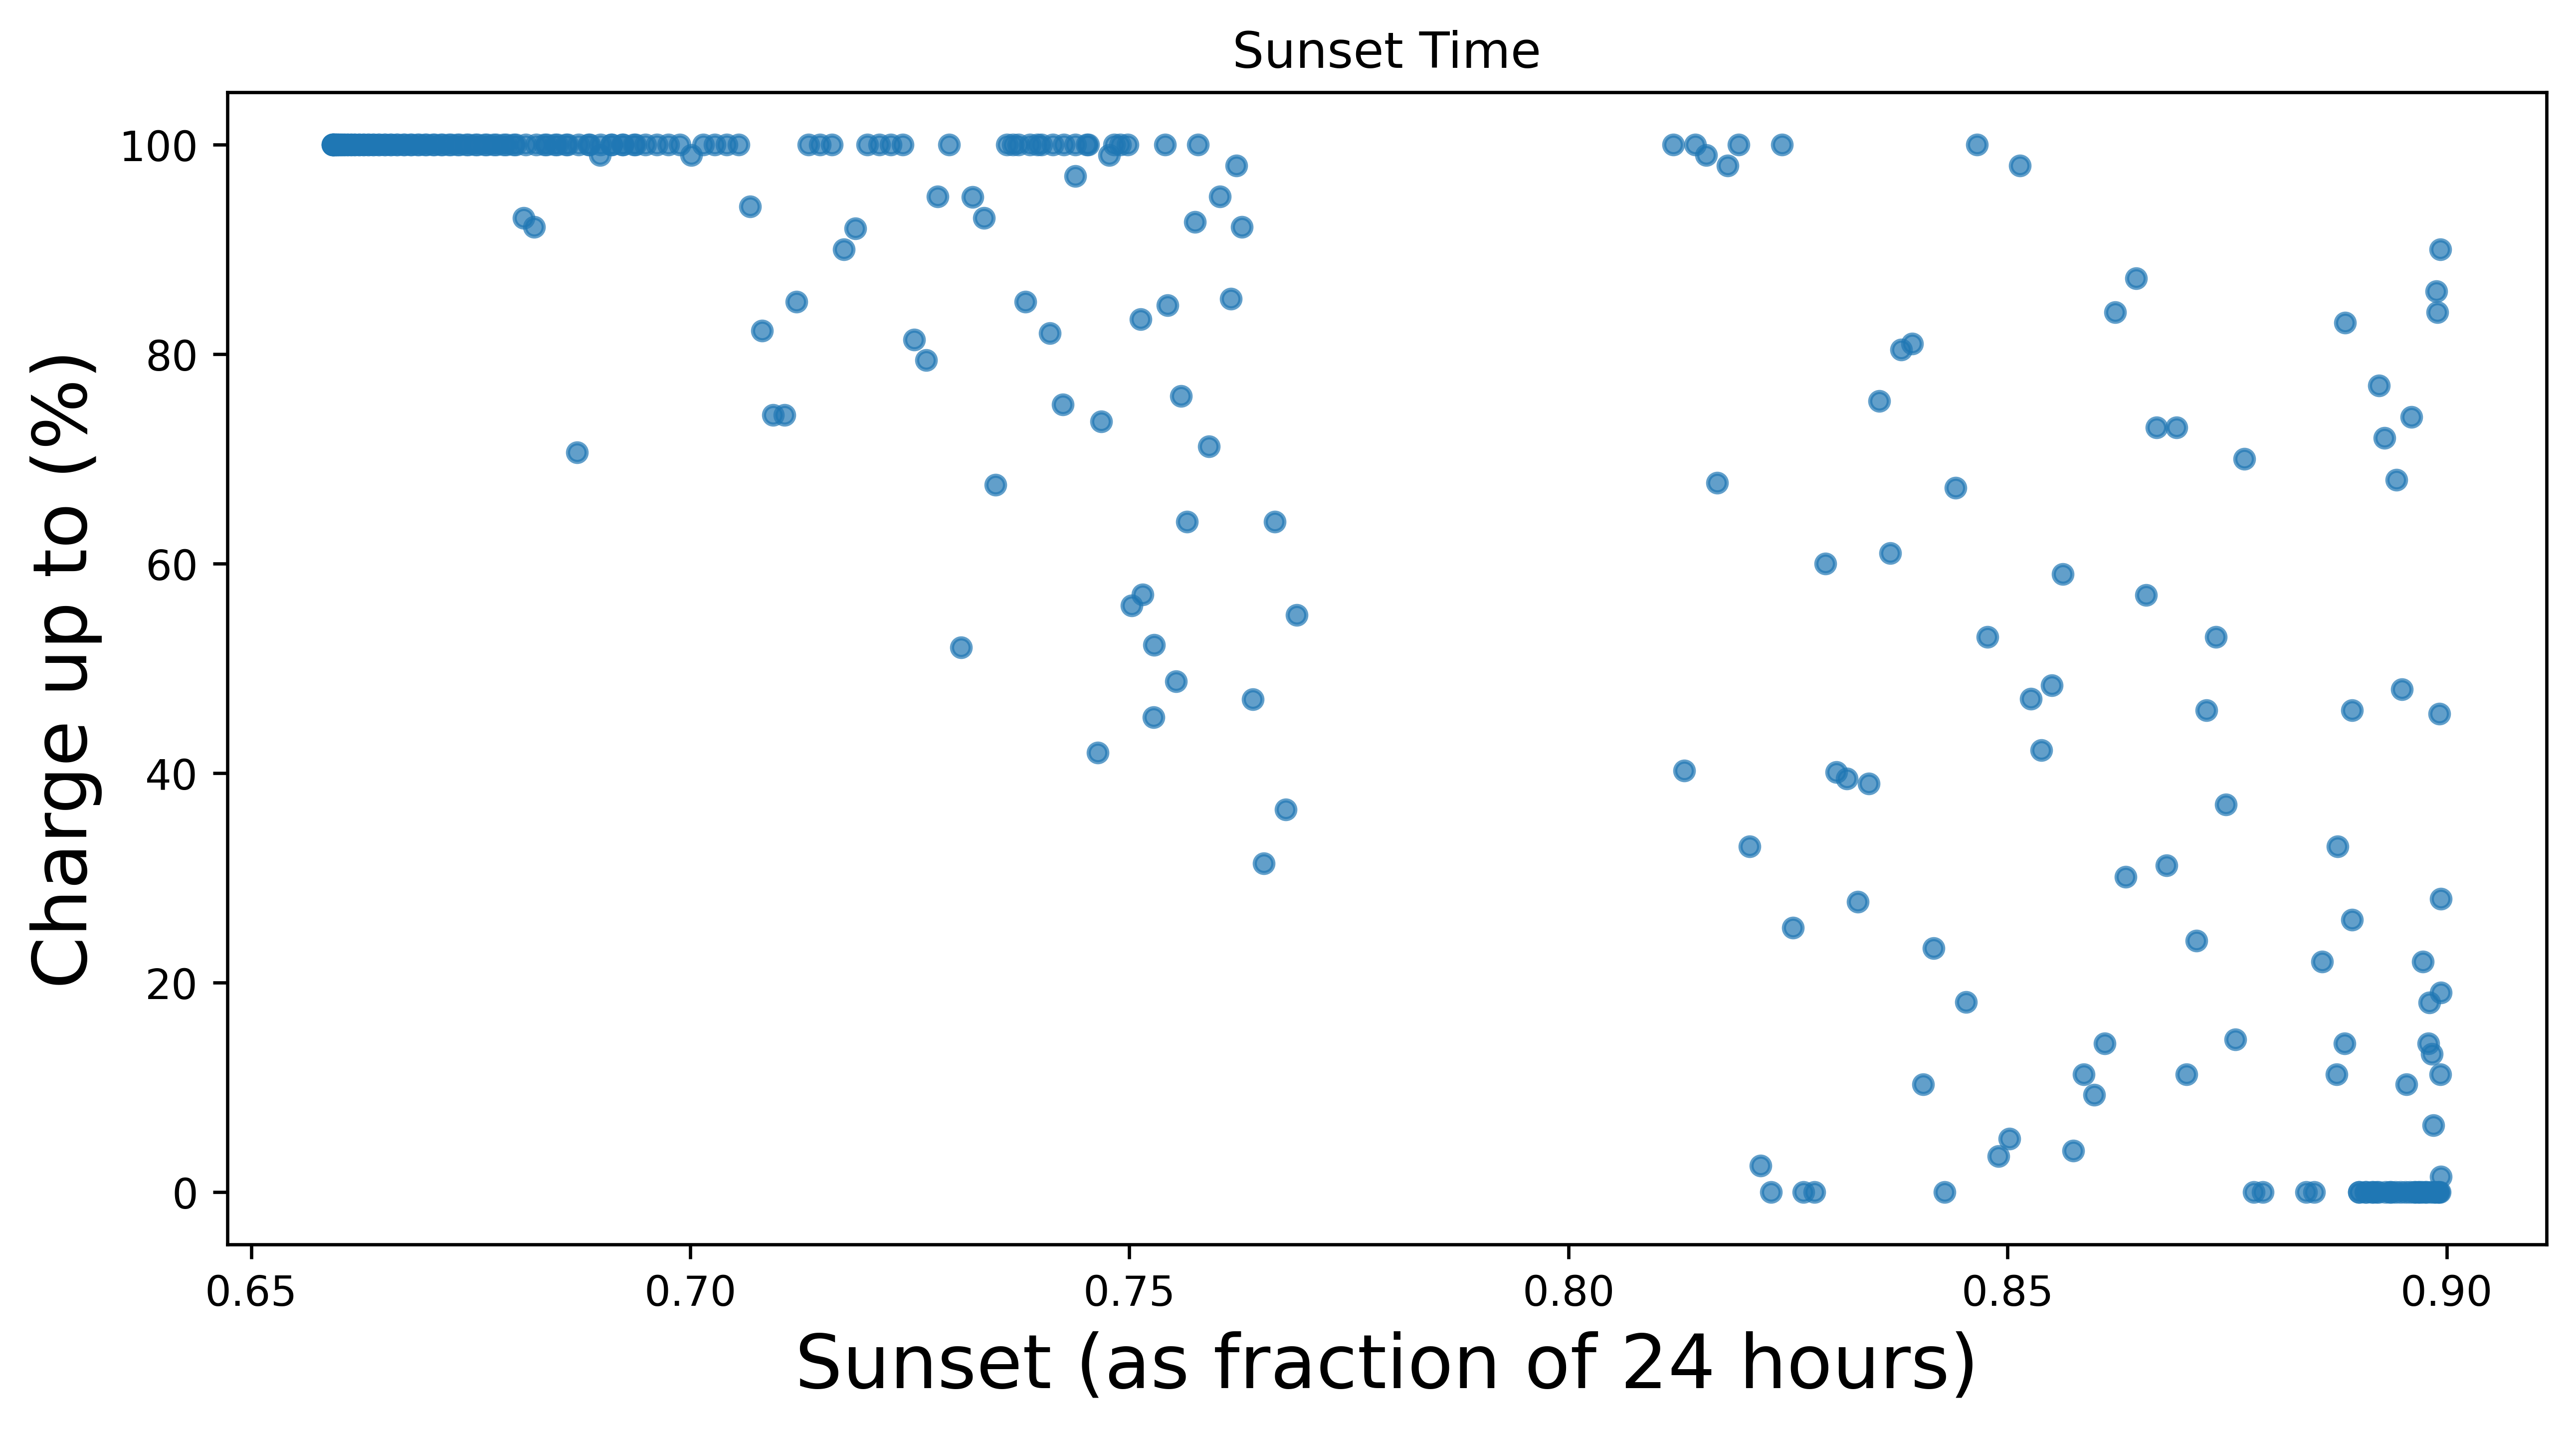

In [17]:
print("Figure 3: Charge up to given Sunset time")
fig, (a1) = plt.subplots(1,1, dpi=600, figsize=(10,5))

combined.plot(x = "sunset", y = "charge_to", kind="scatter", alpha = 0.7, ax=a1)

a1.set_title("Sunset Time")
a1.set_xlabel("Sunset (as fraction of 24 hours)", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)

Figure 2 shows that there is a clear relationship between solar energy and the % to charge the battery to at night. Figure 3 also shows a correlation, however, it is more irregular which is bad for regression.

Figure 4: Spread of % over days


Text(0.5, 1.0, 'Spread of % on Day Type')

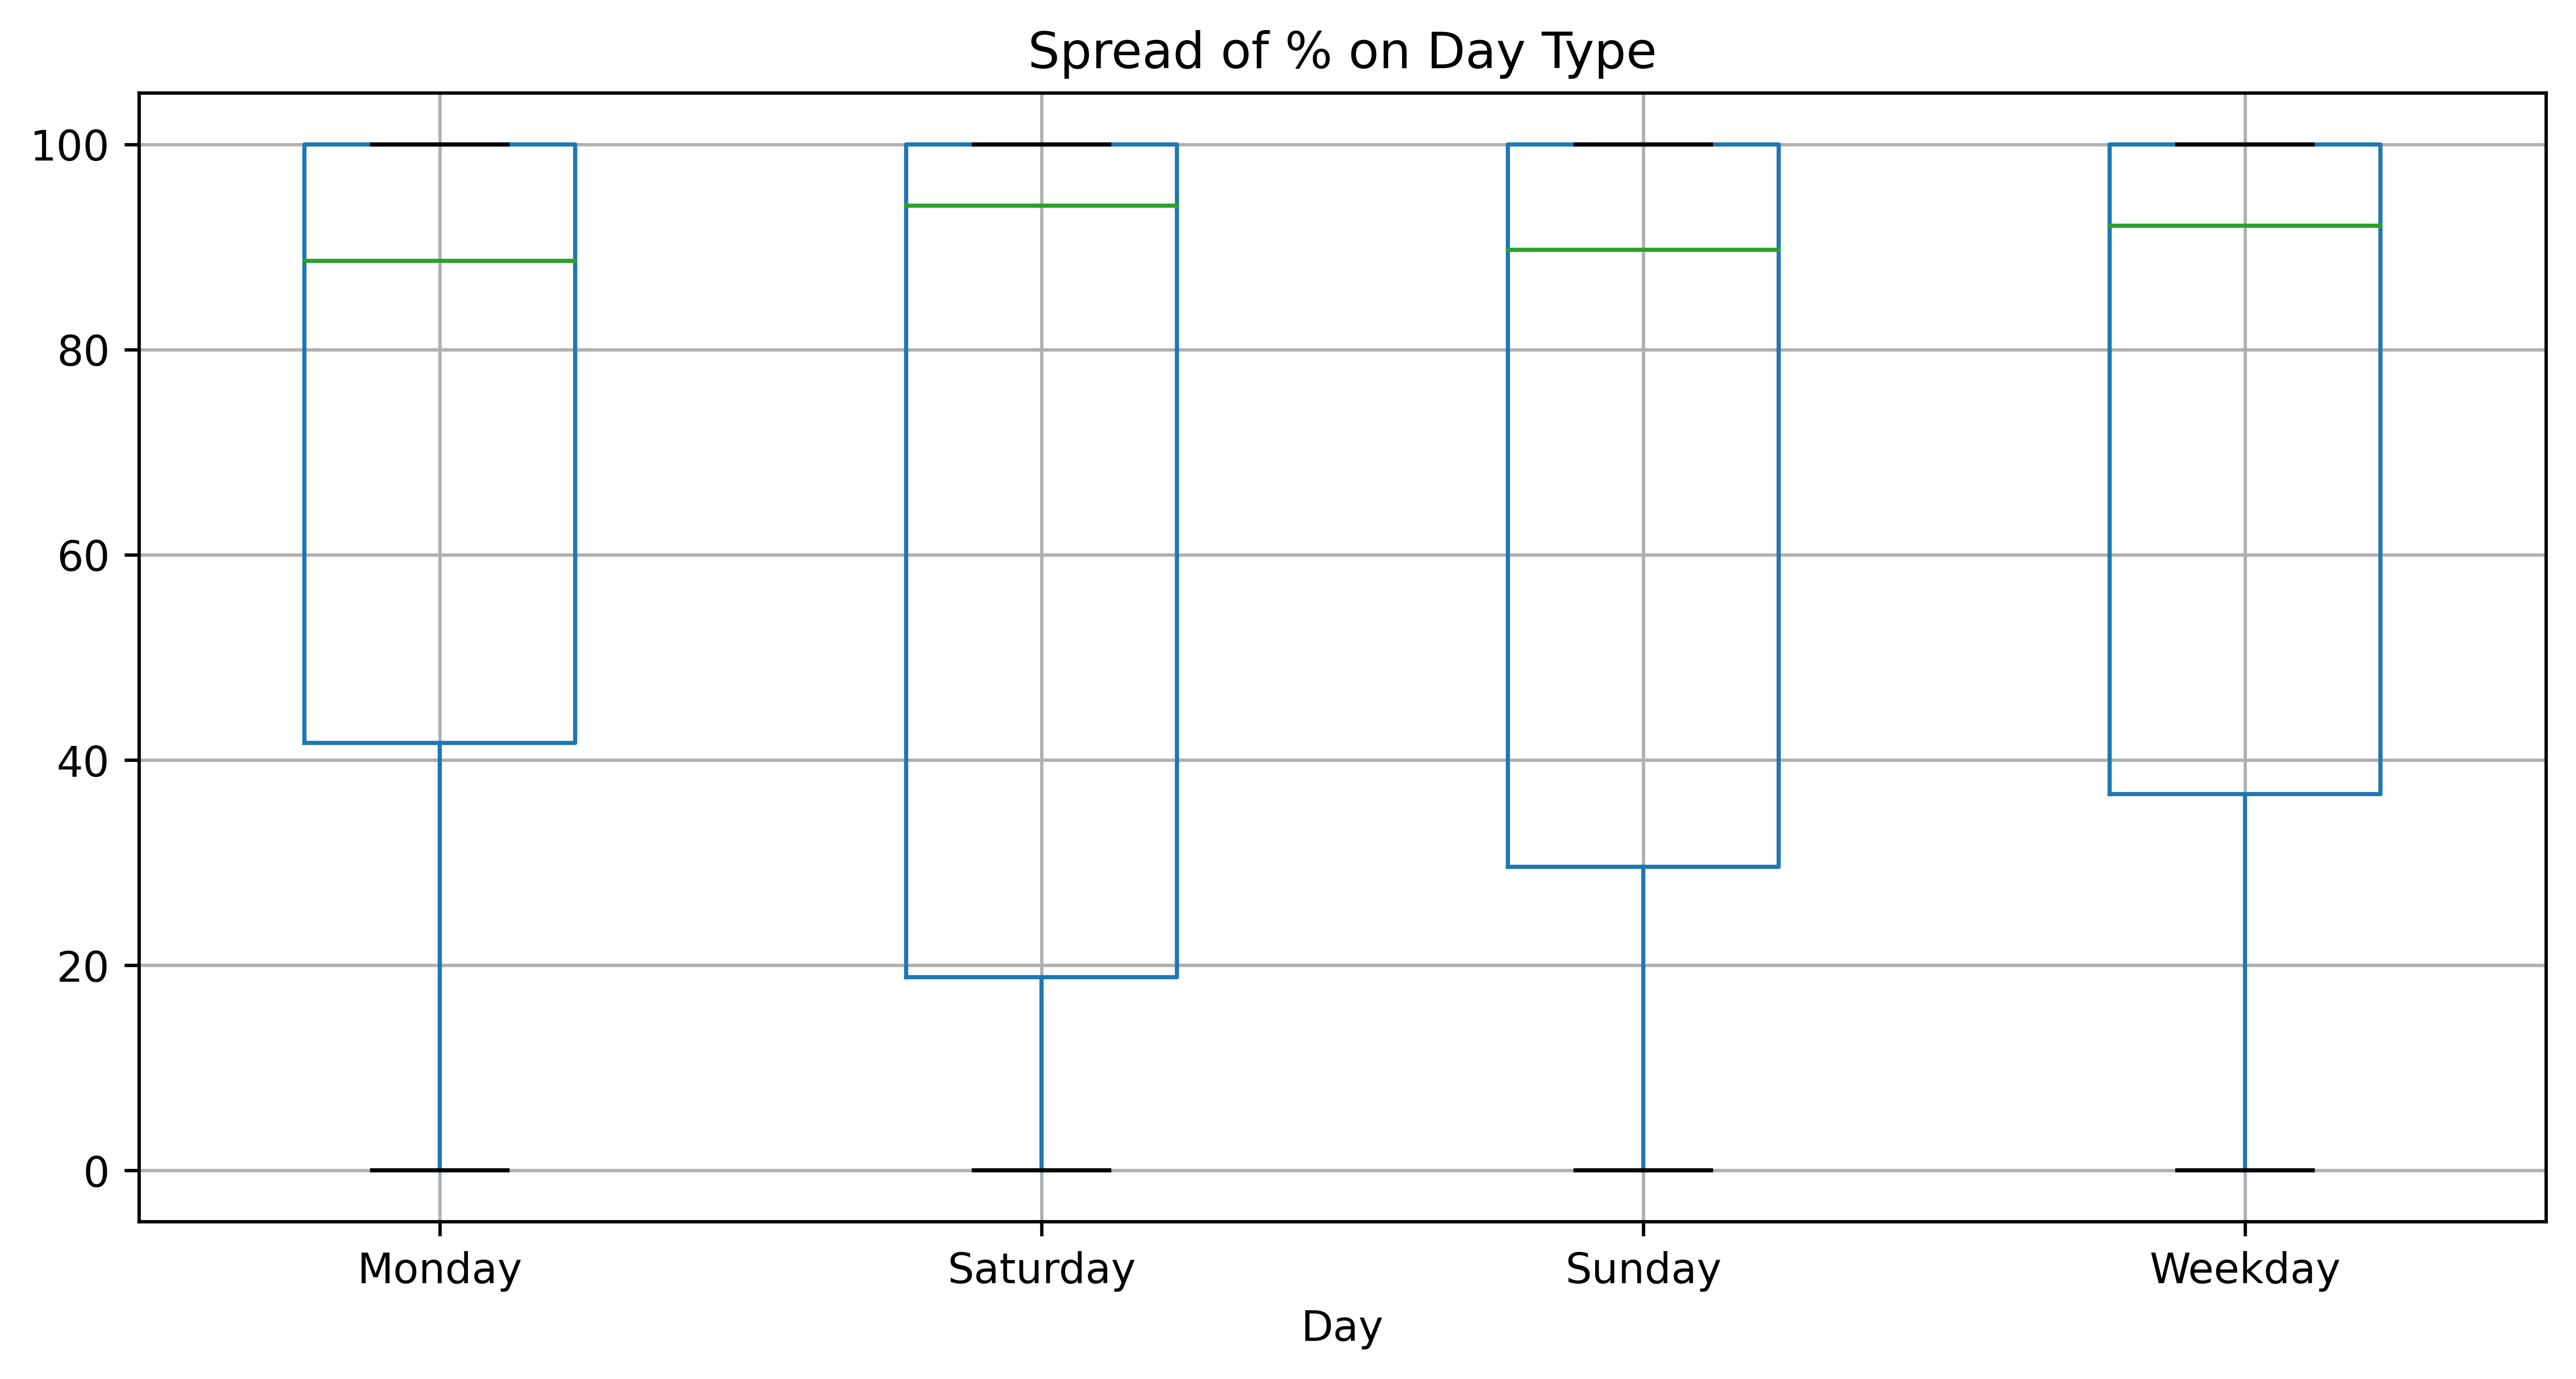

In [18]:
print("Figure 4: Spread of % over days")
fig, a1 = plt.subplots(1,1, figsize=(10,5), dpi=600)

df.boxplot(column='charge_to', by='day', ax=a1)
a1.set_xlabel('Day')
fig.suptitle('')
plt.title("Spread of % on Day Type")

Figure four shows that there is not much difference in spread given days of the week. This is surprising since I would expect more energy to be used when more occupants of the house were present, such as Sunday.

Figure 5: Charge up to given Solar Energy


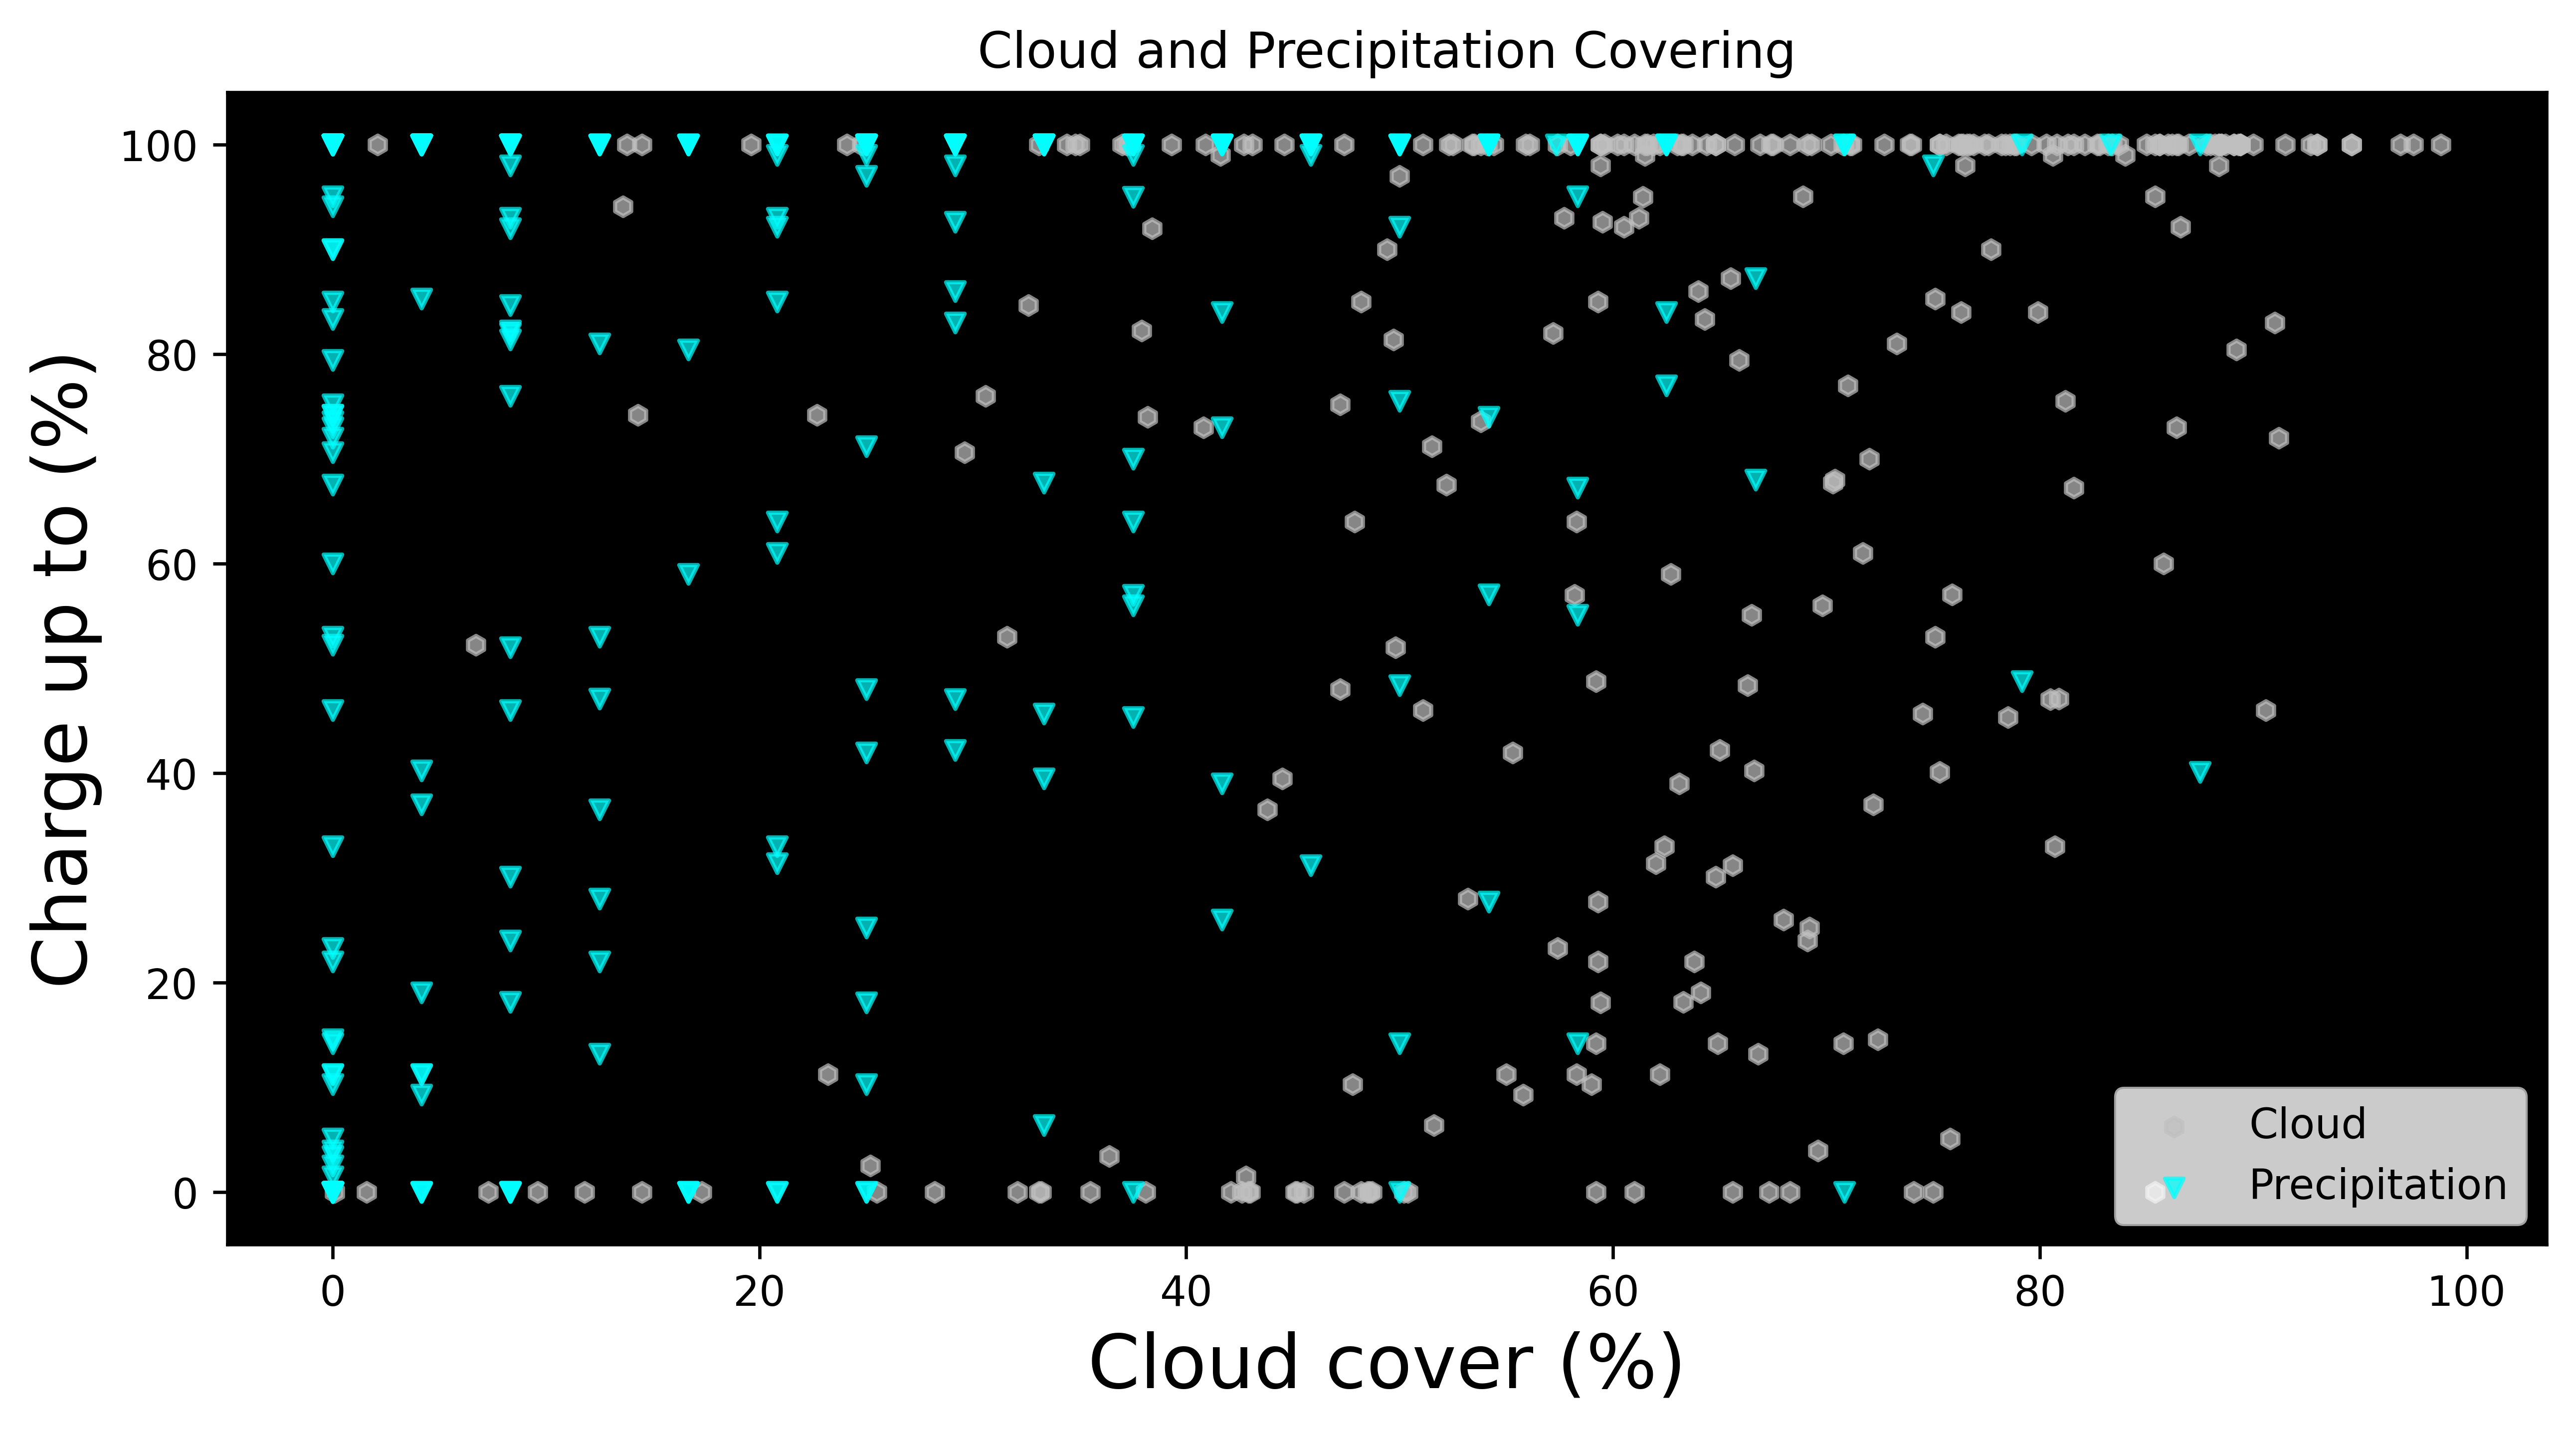

In [19]:
print("Figure 5: Charge up to given Solar Energy")
fig, (a1) = plt.subplots(1,1, dpi=600, figsize=(10,5))

combined.plot(x = "cloud_cover", y = "charge_to", kind="scatter", marker='h', color='silver', alpha = 0.7, ax=a1)
combined.plot(x = "prec_cover", y = "charge_to", kind="scatter", marker='v', color='aqua', alpha = 0.7, ax=a1)

a1.set_title("Cloud and Precipitation Covering")
a1.set_xlabel("Cloud cover (%)", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)
a1.set_facecolor('black')
a1.legend(['Cloud', 'Precipitation'])

Figure 5 highlights how random the cloud and precipitation cover correlates with the charge of the battery.

## 4. Simple Regression 1 Feature ##
### Selection ###
Selecting the one feature solar_energy and preparing for regression

In [53]:
from sklearn.model_selection import train_test_split

selected = combined[["solar_energy", "charge_to"]]
selected

X = combined["solar_energy"].to_numpy()
y = combined["charge_to"].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=2)

In [92]:
import numpy as np

orders = range(1,9)
x_LS = np.linspace(1,30,100).T

MSE_Train = dict.fromkeys(orders)
MSE_Val = dict.fromkeys(orders)

for order in orders:
    p = np.poly1d(np.polyfit(X_train, y_train, int(order)))

    MSE_Train[order] = np.sum((y_train - p(X_train))**2)/10
    MSE_Val[order] = np.sum((y_val - p(X_val))**2)/20

errors = pd.DataFrame({'Order' : orders, 'MSE Train' : list(MSE_Train.values()), 'MSE Val' : list(MSE_Val.values())})
errors

,Order,MSE Train,MSE Val
0,1,5459.102409,664.997523
1,2,4595.346488,679.849598
2,3,3776.174230,515.295526
3,4,3528.981909,464.030400
4,5,3525.952333,464.523144
5,6,3525.943929,464.906015
6,7,3524.200837,464.909065
7,8,3524.172185,465.314820


The coefficients of the fitted model are:
 [-1.16595214e-03  7.95750241e-02 -1.62006932e+00  5.31040790e+00
  9.66515404e+01] 

---

The fitted model is:
            4           3        2
-0.001166 x + 0.07958 x - 1.62 x + 5.31 x + 96.65 

---

The training MSE is: 3528.982 

---

The validation MSE is:  464.030 

---



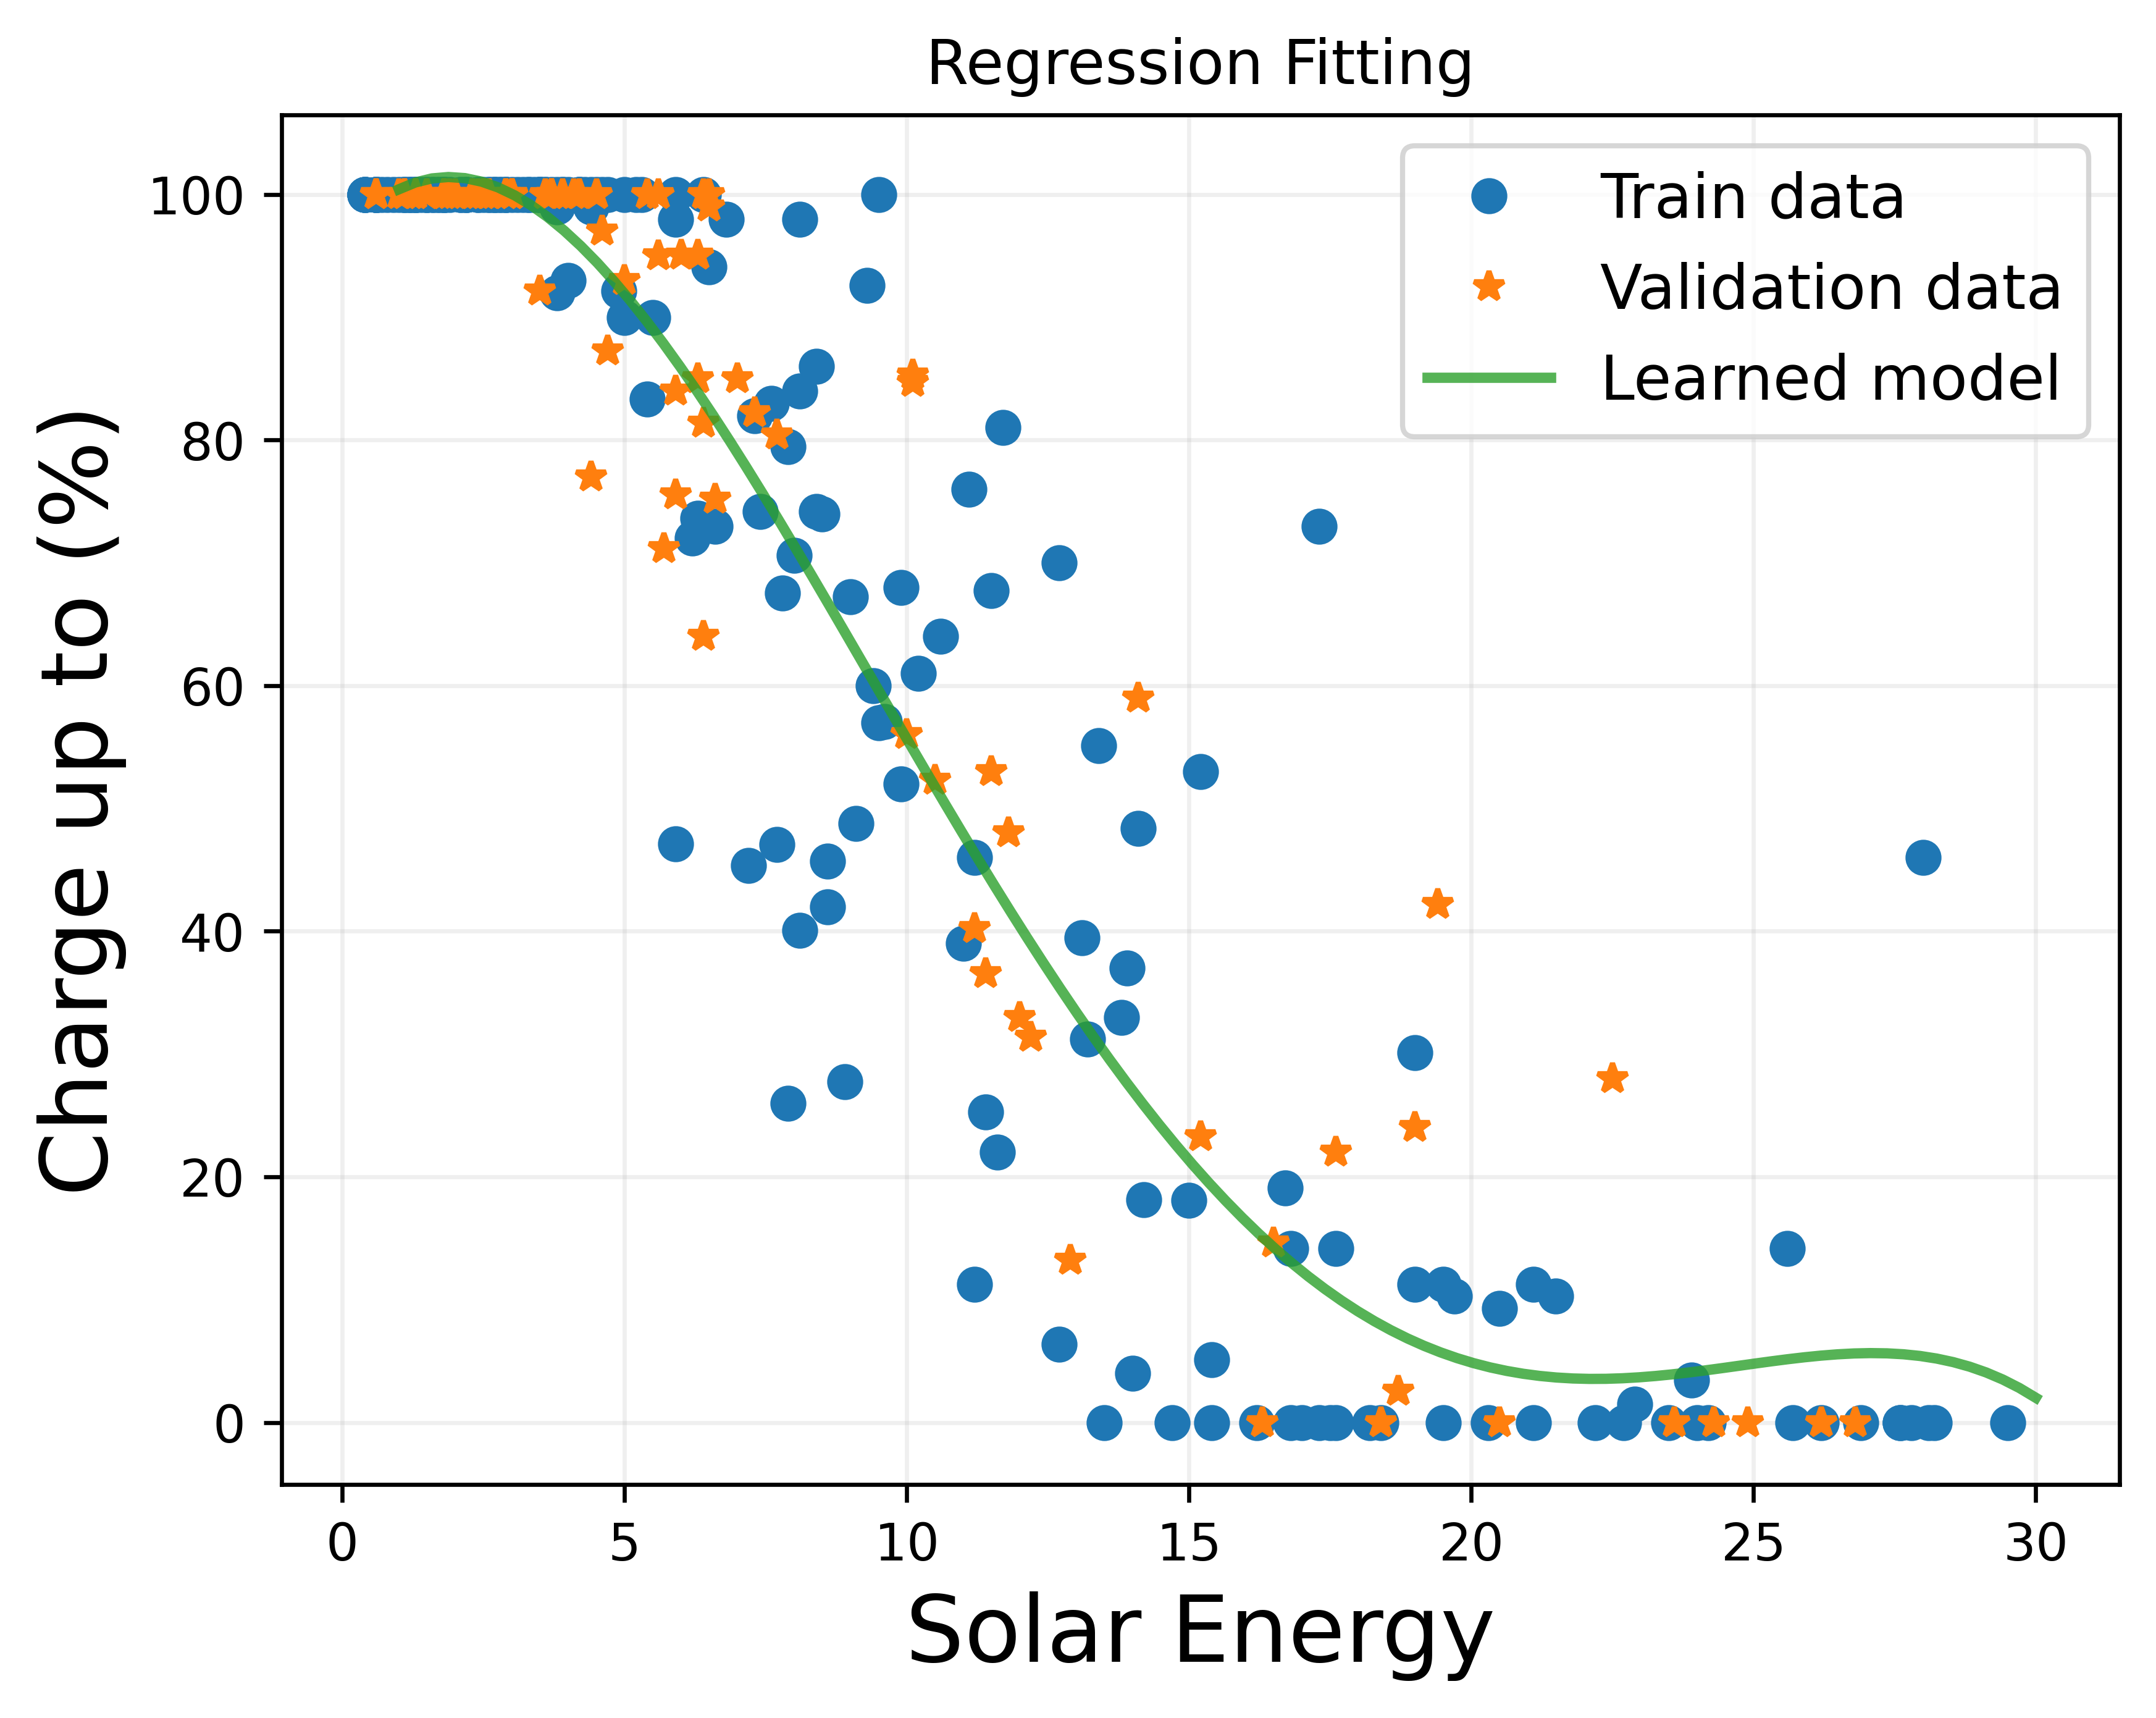

In [99]:
order = 4

p = np.poly1d(np.polyfit(X_train, y_train, int(order)))

MSE_Train[order] = np.sum((y_train - p(X_train))**2)/10
MSE_Val[order] = np.sum((y_val - p(X_val))**2)/20

fig, a1 = plt.subplots(1, 1, dpi = 600)
a1.plot(X_train, y_train, 'o', label='Train data')
a1.plot(X_val, y_val, '*', label='Validation data')
a1.plot(x_LS, p(x_LS), '-', alpha=0.8, label='Learned model', linewidth=2)

a1.set_title("Regression Fitting")
a1.set_xlabel("Solar Energy", fontsize=18)
a1.set_ylabel("Charge up to (%)", fontsize=18)
a1.grid(alpha=0.2)
a1.legend(loc='upper right', fontsize=12)

print('The coefficients of the fitted model are:\n {} \n\n---\n'.format(p.c))
print('The fitted model is:\n {} \n\n---\n'.format(p))
print('The training MSE is: {:8.3f} \n\n---\n'.format(MSE_Train[order]))
print('The validation MSE is: {:8.3f} \n\n---\n'.format(MSE_Val[order]))

In [119]:
energy = float(input("Enter solar energy: "))

if int(p(energy)) > 100:
    bounded = 100
elif int(p(energy)) < 0:
    bounded = 0
else:
    bounded = int(p(energy))

print("Charge to " + str(bounded) + "% tonight")

Enter solar energy: 14.1
Charge to 26% tonight


# From here # 

In [4]:
# minmax scaling, saved in object "scaler" for use on prediction val

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(combined)
normalised = scaler.transform(combined)
normalised[0:10]

array([[0.        , 0.        , 1.        , 0.0952    , 0.60081054,
        0.26460481, 0.42864719, 0.98      ],
       [1.        , 0.        , 0.        , 0.33337143, 0.60182371,
        0.30584192, 0.40897696, 0.92617187],
       [0.        , 1.        , 0.        , 0.0952    , 0.30901722,
        0.36769759, 0.40246842, 0.76      ],
       [0.        , 0.        , 0.        , 0.0952    , 0.32928065,
        0.33333333, 0.39605631, 0.846875  ],
       [0.        , 0.        , 1.        , 0.        , 0.0668693 ,
        0.34707904, 0.3896442 , 0.52273437],
       [0.        , 0.        , 1.        , 0.        , 0.65045593,
        0.17182131, 0.3832803 , 0.83351562],
       [0.        , 0.        , 1.        , 0.47622857, 0.82269504,
        0.01718213, 0.37701283, 1.        ],
       [0.        , 0.        , 1.        , 0.57142857, 0.79128673,
        0.0652921 , 0.37074535, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.54407295,
        0.20274914, 0.364526

In [5]:

from sklearn.linear_model import Ridge #linear regression with regularisation

y = combined.charge_to
#X = np.column_stack((combined.Saturday, combined.Sunday, combined.Weekday, combined.prec_cover, combined.cloud_cover, combined.solar_energy, combined.sunset))
X = normalised

fitter = Ridge(alpha=0.7)
reg = fitter.fit(X, y)

print('The R2 coefficient (goodness of fit) of determination is %4.3f' % reg.score(X, y))
beta_Saturday = reg.coef_[0]
beta_Sunday  = reg.coef_[1]
beta_Weekday = reg.coef_[2]
beta_prec_cover = reg.coef_[3]
beta_cloud_cover = reg.coef_[4]
beta_solar_energy = reg.coef_[5]
beta_sunset = reg.coef_[6]

The R2 coefficient (goodness of fit) of determination is 0.999


Error distribution, predicted vs actual


(-10.0, 10.0)

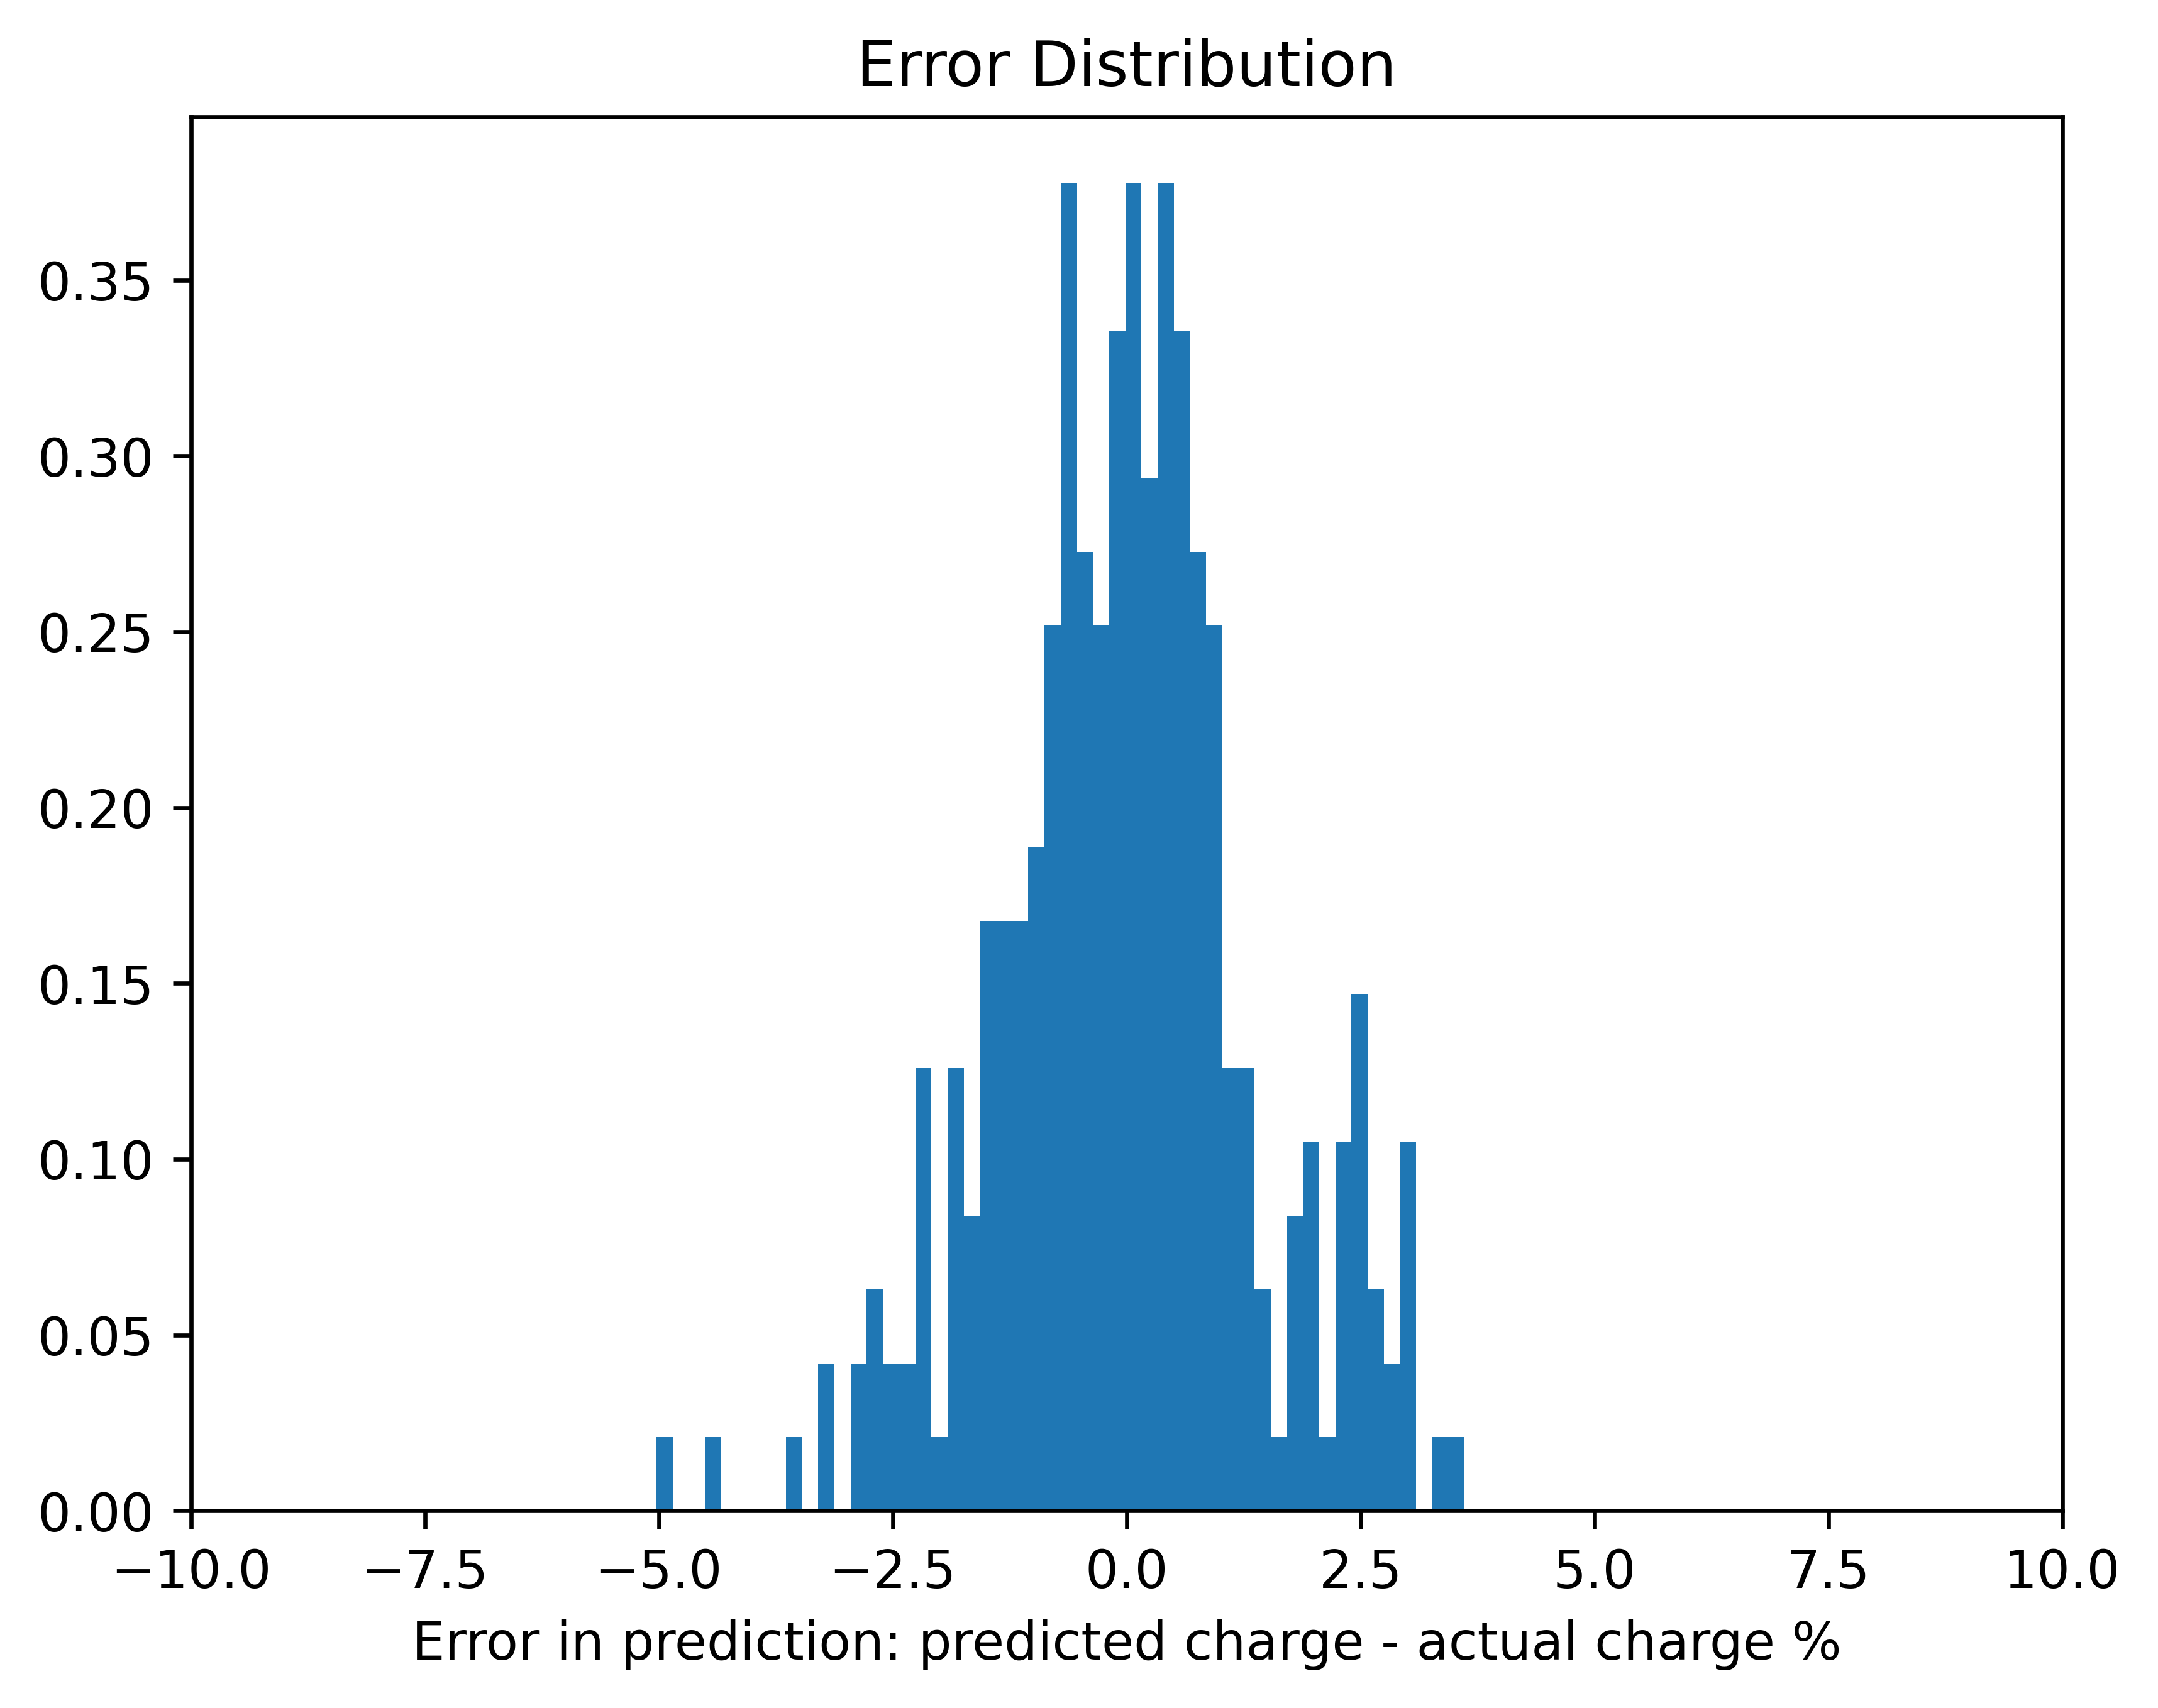

In [6]:
import matplotlib.pyplot as plt

print("Error distribution, predicted vs actual")
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1, dpi = 600)
residuals = y_hat - y
a1.hist(residuals, bins=50, density=True)
a1.set_xlabel('Error in prediction: predicted charge - actual charge %')
a1.set_title("Error Distribution")
a1.set_xlim(-10,10)

In [7]:
coefficients = pd.DataFrame({'Factor' : ['Saturday', 'Sunday', 'Weekday', 'Precipitation', 'cloud', 'Solar', 'Sunset'],
                   'Regression Coefficient' : [beta_Saturday, beta_Sunday, beta_Weekday, beta_prec_cover, beta_cloud_cover,
                                               beta_solar_energy, beta_sunset]})

coefficients = coefficients.round(3)
print("Table 11: Numeric Coefficients Table")
coefficients

Table 11: Numeric Coefficients Table


,Factor,Regression Coefficient
0,Saturday,-0.064
1,Sunday,-0.069
2,Weekday,-0.190
3,Precipitation,0.127
4,cloud,0.601
5,Solar,-8.849
6,Sunset,-3.028


In [ ]:
#inputs
saturday = float(input("Enter 1 if Saturday, else 0: "))
sunday = float(input("Enter 1 if Sunday, else 0: "))
weekday = float(input("Enter 1 if Weekday (EXCLUDING MONDAY), else 0: "))
precipitation = float(input("Enter precipitation cover %: "))
cloud_cover = float(input("Enter cloud cover %: "))
solar_energy = float(input("Enter solar energy: "))
sunset_hours = float(input("Enter hour of sunset (0-23): "))
sunset_min = float(input("Enter minute of sunset (0-59): "))
sunset_sec = float(input("Enter second of sunset (0-59): "))

#working out sunset time as a fraction of day
sunset = ((sunset_hours*60*60)+(sunset_min*60)+sunset_sec)/86400
print("Sunset as a fraction is: {}".format(sunset))

#making prediction array from inputs and normalising by same as the dataset "scaler" object
pred_array = np.array([[saturday, sunday,  weekday,  precipitation, cloud_cover, solar_energy, sunset, 100]])
norm_pred_array = scaler.transform(pred_array)

to_predict = norm_pred_array[0, :-1].reshape(1,7)

X_predict = norm_pred_array
y_predict = reg.predict(X_predict)

print("\n Predicted charge up to at night: {}%".format(int(y_predict)))